In [1]:
import numpy as np
import torch
import networkx as nx
import difflib
import matplotlib.pyplot as plt

### Defining model parameters

In [2]:
N = 100 # No. of input nodes i.e. behaviours
R = 100 # No. of descending neurons i.e. bottleneck layer
M = N # No. of motor units, output
n = 5 # No. of responding output nodes
fn = n/M # Fraction of output nodes that are responding
response_threshold = 0.5 # Whether an input corresponds to activating the node or not
loss_series = []

### Binary inputs

In [4]:
x_in = [[1 if i==j else 0 for i in range(N)] for j in range(N)]
x = torch.tensor(x_in).float()
#print(x_input)

### Output

* I'm generating outputs where the number of responding nodes is distributed with mean n but this can be changed to fix n = 5 as in our previous code. I don't think this should change anything. Let me know if it does change the training somehow, I can fix it!

In [3]:
def xout(m,rate):
    x_out = []
    for i in range(m):
        x_out.append(np.random.choice([0,1],size=m,p=(1-rate,rate)))
    return x_out

In [5]:
# Defining the output tensor
y = torch.tensor(xout(M,fn)).float()

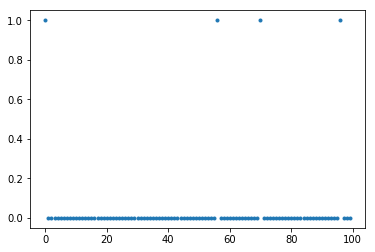

In [15]:
plt.figure()
plt.plot(y[0].detach().numpy(), '.')
plt.show()

### Defining the model for Pytorch

* We have one hidden layer with sigmoid activation in addition to the input and output layers. We want to binarize the output so there is another sigmoid activation on it.
* Defining the optimization routine. Here we use stochastic gradient descent with momentum = 0.9. This helps move between local minima in order to reach the global minimum.

In [17]:
learning_rate = 1e0
epochs = int(1e5)

In [20]:
model = torch.nn.Sequential(
          torch.nn.Linear(N, R),
          torch.nn.Sigmoid(),
          torch.nn.Linear(R,M),
          torch.nn.Sigmoid())
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [21]:
%%timeit
for t in range(10):
    # Run the forward pass
    y_pred = model(x)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    loss_series.append(loss.item())
  
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights using SGD
    optimizer.step()

7.44 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
7.44*10**4/1000/60

1.24

### Example plot of the training output 

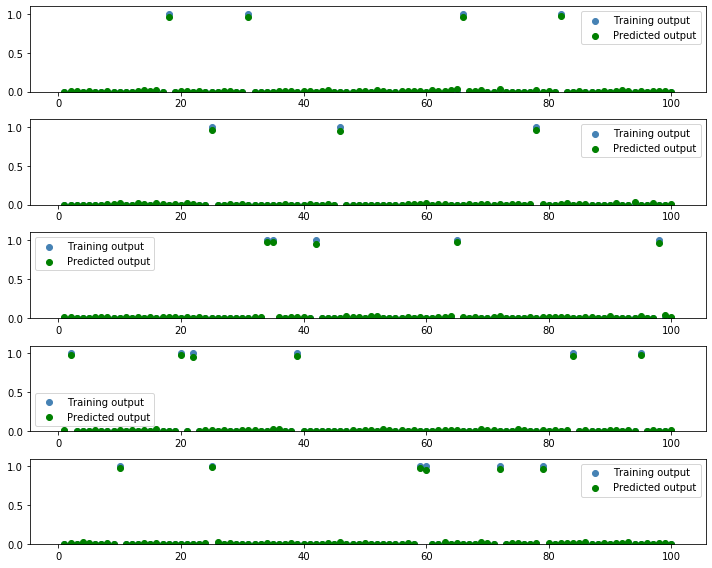

In [9]:
plt.figure(1,figsize=(10,8))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,1.1)
    plt.scatter(np.arange(1,N+1,1),y[i],color='steelblue',label='Training output')
    plt.scatter(np.arange(1,N+1,1),y_pred[i].data.numpy(),color='green',label='Predicted output')
    plt.legend()
plt.tight_layout()
plt.show()

### Plotting the loss as a function of the epochs

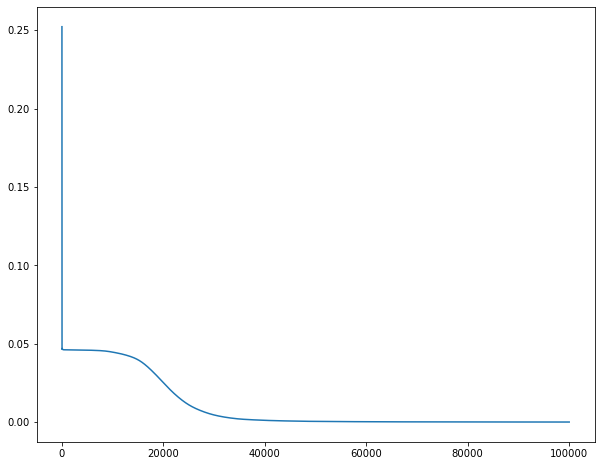

In [10]:
plt.figure(2,figsize=(10,8))
plt.plot(range(epochs),loss_series)
plt.show()

### Calculating the number of behaviours learnt

In [11]:
per = 0.99
threshold = 0.5
behaviour = 0
behaviours_learnt = []
y_pred_binary = np.abs(np.round(y_pred.data.numpy()+0.5-threshold))
for j in range(len(y)):
    s = difflib.SequenceMatcher(None, y.data.numpy()[j],y_pred_binary[j])
    if s.ratio() > per:
        behaviour += 1
    behaviours_learnt.append(behaviour/N)

In [12]:
behaviour

100

### Extracting trained weights and biases

In [39]:
trained_parameters = []
for param in model.named_parameters():
    trained_parameters.append(param[1].data.numpy())
    
w1 = trained_parameters[0]
b1 = trained_parameters[1]
w2 = trained_parameters[2]
b2 = trained_parameters[3]

# Import trained weights and biases

In [30]:
w1 = torch.tensor(np.loadtxt(r"weights1_100_100.0.dat".format(N,R)), dtype=torch.float32)
w2 = torch.tensor(np.loadtxt(r"weights2_100_100.0.dat".format(N,R)), dtype=torch.float32)
b1 = torch.tensor(np.loadtxt(r"bias1_100_100.0.dat".format(N,R)), dtype=torch.float32)
b2 = torch.tensor(np.loadtxt(r"bias2_100_100.0.dat".format(N,R)), dtype=torch.float32)

In [32]:
it = 0
x = torch.tensor(np.genfromtxt(r"k_5_behaviors/x_{}.csv".format(it), delimiter=',')).float()
y = torch.tensor(np.genfromtxt(r"k_5_behaviors/y_{}.csv".format(it), delimiter=',')).float()


In [34]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

In [36]:
# Using the saved weights to generate predict outputs
y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
y_pred = y_pred.detach().numpy()
y_orig = y.detach().numpy()

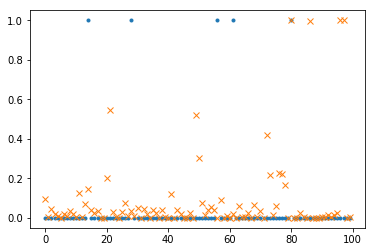

In [38]:
beh_ind = 0
plt.figure()
plt.plot(y_orig[beh_ind], '.')
plt.plot(y_pred[beh_ind], 'x')
